### 4.1 import section

In [42]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from  sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix,classification_report
import matplotlib.pyplot as plt
from sklearn import tree
import warnings
warnings.filterwarnings('ignore')
import operator
import copy
import json
import pickle
from collections import Counter
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from lightgbm import LGBMClassifier
import warnings
import sqlite3
import os
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

### 4.2 Reading data from file

In [2]:
X = pd.read_csv('final_features.csv',nrows = 10000)
y = X['is_duplicate']
X.drop(['Unnamed: 0', 'id','is_duplicate'],axis = 1,inplace = True)
X.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,...,16.165592,33.030668,7.019996,-14.793959,15.437511,8.199658,-25.070834,1.571619,1.603738,0.305645
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,-4.901128,-4.565393,41.520751,-0.727564,-16.413776,-7.373778,2.638877,-7.403457,2.703070,0.408040
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,8.359966,-2.165985,10.936580,-16.531660,14.681230,15.633759,-1.210901,14.183826,11.703135,10.148075
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,...,3.311411,3.788879,13.398598,-6.592596,6.437365,5.993293,2.732392,-3.727647,5.614115,6.023693
4,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,...,-2.403870,11.991204,8.088483,-15.090201,8.375166,1.727225,-6.601129,11.317413,11.544603,2.478689


### 4.3 Random train test split( 70:30)

In [3]:
X_train,X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7000, 794)
(3000, 794)
(7000,)
(3000,)


In [4]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output test in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
---------- Distribution of output test in train data ----------
Class 0:  0.629 Class 1:  0.371


### 4.4 Creating result dataset and metrics function

In [5]:
result_dataset = pd.DataFrame(data =np.zeros((4,6)) , index = ['accuracy_score','f1_score','roc_auc_score','log_loss'],columns = ['Random','LR','SVC','DT','RF','XGB'])
result_dataset

,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.0,0.0,0.0,0.0,0.0,0.0
f1_score,0.0,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.0,0.0,0.0,0.0,0.0,0.0
log_loss,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def metrics(classfier,X_test,y_test,name):
  if isinstance(classfier, list):
    y_pred = classfier[1]
    y_prob = classfier[0][:,1]
  else:
    y_pred = classfier.predict(X_test)
    y_prob = classfier.predict_proba(X_test)[:,[1]]
  accuracy = accuracy_score(y_test,y_pred)
  rocauc = roc_auc_score(y_test,y_prob)
  logloss = log_loss(y_test,y_prob,eps=1e-15)
  f1score = f1_score(y_test,y_pred)
  result_dataset[name]['accuracy_score'] = accuracy
  result_dataset[name]['f1_score'] = f1score
  result_dataset[name]['roc_auc_score'] = rocauc
  result_dataset[name]['log_loss'] = logloss
  print("accuracy score :",accuracy)
  print("f1 score :",f1score)
  print("auc score :",rocauc)
  print("log loss :",logloss)
  print('classification report : \n', classification_report(y_test,y_pred))
  print('*********** confusion matrx ***********')
  C = confusion_matrix(y_test, y_pred)
  A =(((C.T)/(C.sum(axis=1))).T)
  B =(C/C.sum(axis=0))
  plt.figure(figsize=(20,4))
  labels = [1,2]
  cmap=sns.light_palette("blue")
  plt.subplot(1, 3, 1)
  sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Confusion matrix")
  
  plt.subplot(1, 3, 2)
  sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Precision matrix")
  
  plt.subplot(1, 3, 3)
  # representing B in heatmap format
  sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.title("Recall matrix")
  plt.show()

### 4.5 Building a random model (Finding worst-case log-loss)

accuracy score : 0.49633333333333335
f1 score : 0.43002640513013957
auc score : 0.5140034596194418
log loss : 0.8687353033708989
classification report : 
               precision    recall  f1-score   support

           0       0.63      0.49      0.55      1887
           1       0.37      0.51      0.43      1113

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.49      3000
weighted avg       0.53      0.50      0.50      3000

*********** confusion matrx ***********


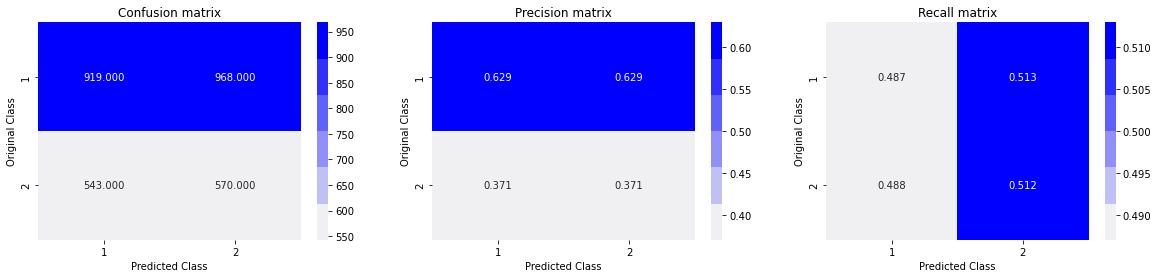

,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.0,0.0,0.0,0.0,0.0
f1_score,0.430026,0.0,0.0,0.0,0.0,0.0
roc_auc_score,0.514003,0.0,0.0,0.0,0.0,0.0
log_loss,0.868735,0.0,0.0,0.0,0.0,0.0


In [8]:
rand_y_prob = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    rand_y_prob[i] = ((rand_probs/sum(sum(rand_probs)))[0])
rand_y_pred =np.argmax(rand_y_prob, axis=1)
metrics([rand_y_prob,rand_y_pred],X_test,y_test,'Random')
result_dataset

## lets start with logistic regression

In [30]:
logistic_clf = SGDClassifier(loss = 'log')
param_grids = {'base_estimator__alpha': [0.000001,0.00001,0.0001, 0.001, 0.01,0.1,1.0],'base_estimator__penalty' : ['l1','l2','elasticnet'], 'method' : ['sigmoid','isotonic']}
#param_grids = {'base_estimator__penalty' : ['l1','l2','elasticnet'], 'method' : ['sigmoid','isotonic']}
logistic_classif = GridSearchCV(estimator = CalibratedClassifierCV(base_estimator = logistic_clf),param_grid = param_grids,cv = 2, scoring = 'neg_log_loss',verbose = 2,n_jobs=-1)
logistic_classif.fit(X_train,y_train)
logistic_classif.best_estimator_


Fitting 2 folds for each of 42 candidates, totalling 84 fits


/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/santhoshkurnapally/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_it

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1, loss='log',
                                                    penalty='elasticnet'),
                       method='isotonic')

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.1, loss='log',penalty='elasticnet'),method='isotonic')

accuracy score : 0.7496666666666667
f1 score : 0.5843940232429441
auc score : 0.8332335824011741
log loss : 0.4838266481047292
classification report : 
               precision    recall  f1-score   support

           0       0.75      0.91      0.82      1887
           1       0.76      0.47      0.58      1113

    accuracy                           0.75      3000
   macro avg       0.75      0.69      0.70      3000
weighted avg       0.75      0.75      0.73      3000

*********** confusion matrx ***********


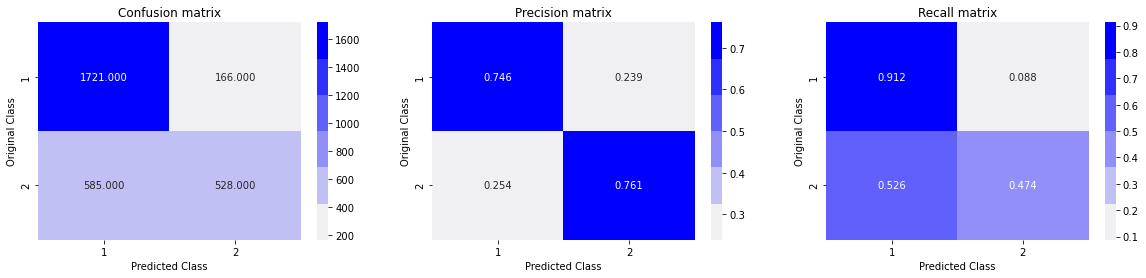

********* dataset *********


,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.749667,0.0,0.0,0.0,0.0
f1_score,0.430026,0.584394,0.0,0.0,0.0,0.0
roc_auc_score,0.514003,0.833234,0.0,0.0,0.0,0.0
log_loss,0.868735,0.483827,0.0,0.0,0.0,0.0


[CV] END base_estimator__alpha=1e-06, base_estimator__penalty=l2, method=isotonic; total time=   4.8s
[CV] END base_estimator__alpha=1e-06, base_estimator__penalty=elasticnet, method=isotonic; total time=  10.0s
[CV] END base_estimator__alpha=1e-05, base_estimator__penalty=l2, method=sigmoid; total time=   4.9s
[CV] END base_estimator__alpha=1e-05, base_estimator__penalty=elasticnet, method=isotonic; total time=  10.5s
[CV] END base_estimator__alpha=0.0001, base_estimator__penalty=l2, method=isotonic; total time=   5.2s
[CV] END base_estimator__alpha=0.001, base_estimator__penalty=l1, method=sigmoid; total time=  37.4s
[CV] END base_estimator__alpha=0.01, base_estimator__penalty=elasticnet, method=sigmoid; total time=  13.3s
[CV] END base_estimator__alpha=0.1, base_estimator__penalty=l1, method=isotonic; total time= 1.9min
[CV] END base_estimator__alpha=1.0, base_estimator__penalty=l2, method=sigmoid; total time=   5.8s
[CV] END base_estimator__alpha=1.0, base_estimator__penalty=elasti

In [31]:
logistic_clf = logistic_classif.best_estimator_
logistic_clf.fit(X_train,y_train)
metrics(logistic_clf,X_test,y_test,name='LR')
print('********* dataset *********')
result_dataset

## Support Vector Classification

In [32]:
svc_clf = SVC(random_state = 42)
#param_grids = {'base_estimator__C': [0.001, 0.01, 1.0, 10.0],'base_estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'method' : ['sigmoid','isotonic']}
param_grids = {'base_estimator__C': [0.001],'base_estimator__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],'method' : ['sigmoid','isotonic']}
svc_clf = GridSearchCV(estimator = CalibratedClassifierCV(base_estimator = svc_clf),param_grid = param_grids,cv = 2, scoring = 'neg_log_loss',verbose = 2,n_jobs=-1)
svc_clf.fit(X_train,y_train)
svc_clf.best_estimator_

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END base_estimator__C=0.001, base_estimator__kernel=poly, method=isotonic; total time= 1.4min
[CV] END base_estimator__C=0.001, base_estimator__kernel=rbf, method=sigmoid; total time= 1.7min
[CV] END base_estimator__C=0.001, base_estimator__kernel=sigmoid, method=sigmoid; total time= 1.3min
[CV] END base_estimator__C=0.001, base_estimator__kernel=poly, method=sigmoid; total time= 1.4min
[CV] END base_estimator__C=0.001, base_estimator__kernel=rbf, method=sigmoid; total time= 1.7min
[CV] END base_estimator__C=0.001, base_estimator__kernel=sigmoid, method=sigmoid; total time= 1.3min
[CV] END base_estimator__C=0.001, base_estimator__kernel=poly, method=isotonic; total time= 1.4min
[CV] END base_estimator__C=0.001, base_estimator__kernel=rbf, method=isotonic; total time= 1.7min
[CV] END base_estimator__C=0.001, base_estimator__kernel=sigmoid, method=isotonic; total time= 1.3min
[CV] END base_estimator__C=0.001, base_estimator

CalibratedClassifierCV(base_estimator=SVC(C=0.001, kernel='linear',
                                          random_state=42),
                       method='isotonic')

CalibratedClassifierCV(base_estimator=SVC(C=0.001, kernel='linear',
                                          random_state=42),
                       method='isotonic')

accuracy score : 0.7563333333333333
f1 score : 0.6178776790381599
auc score : 0.8323384427712951
log loss : 0.47379845974827683
classification report : 
               precision    recall  f1-score   support

           0       0.76      0.89      0.82      1887
           1       0.74      0.53      0.62      1113

    accuracy                           0.76      3000
   macro avg       0.75      0.71      0.72      3000
weighted avg       0.75      0.76      0.75      3000

*********** confusion matrx ***********


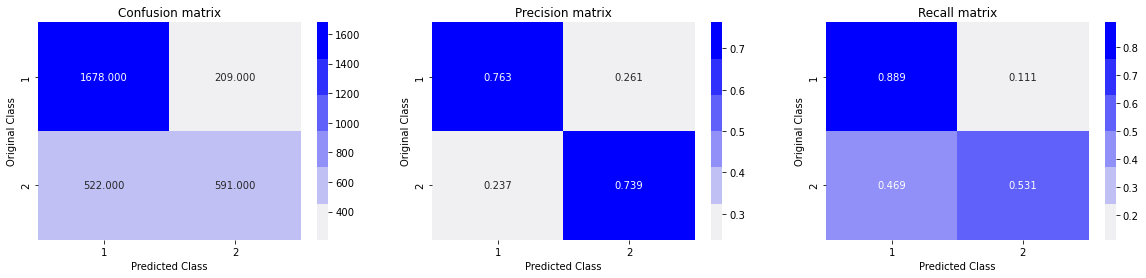

********* dataset *********


,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.749667,0.756333,0.0,0.0,0.0
f1_score,0.430026,0.584394,0.617878,0.0,0.0,0.0
roc_auc_score,0.514003,0.833234,0.832338,0.0,0.0,0.0
log_loss,0.868735,0.483827,0.473798,0.0,0.0,0.0


In [35]:
svc_clf = svc_clf.best_estimator_
svc_clf.fit(X_train,y_train)
metrics(svc_clf,X_test,y_test,name='SVC')
print('********* dataset *********')
result_dataset

## Decision Trees

In [38]:
dt_clf = DecisionTreeClassifier(random_state = 42)
#param_grids = {'base_estimator__criterion': ['gini','entropy'],'base_estimator__max_depth' : [10,15,20,25,30,35,40,50],'method' : ['sigmoid','isotonic']}
param_grids = {'base_estimator__max_depth' : [10],'method' : ['sigmoid','isotonic']}
dt_clf = GridSearchCV(estimator = CalibratedClassifierCV(base_estimator = dt_clf),param_grid = param_grids,cv = 2, scoring = 'neg_log_loss',verbose = 2,n_jobs=-1)
dt_clf.fit(X_train,y_train)
dt_clf.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                             random_state=42),
                       method='isotonic')

accuracy score : 0.7833333333333333
f1 score : 0.6549893842887473
auc score : 0.8734401120638634
log loss : 0.46688892460385145
classification report : 
               precision    recall  f1-score   support

           0       0.78      0.92      0.84      1887
           1       0.80      0.55      0.65      1113

    accuracy                           0.78      3000
   macro avg       0.79      0.74      0.75      3000
weighted avg       0.79      0.78      0.77      3000

*********** confusion matrx ***********


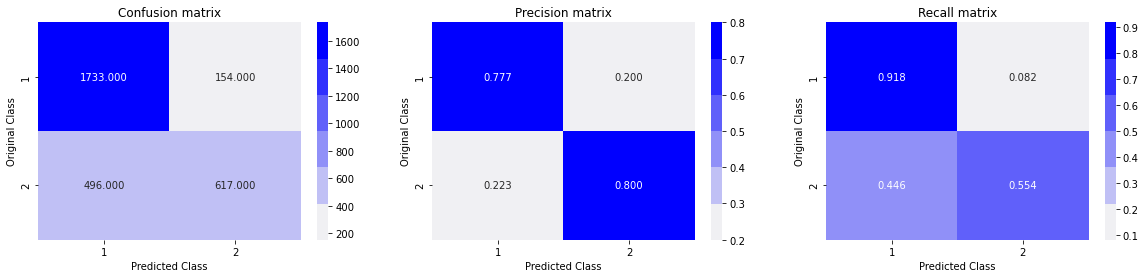

********* dataset *********


,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.749667,0.756333,0.783333,0.0,0.0
f1_score,0.430026,0.584394,0.617878,0.654989,0.0,0.0
roc_auc_score,0.514003,0.833234,0.832338,0.873440,0.0,0.0
log_loss,0.868735,0.483827,0.473798,0.466889,0.0,0.0


[CV] END .......base_estimator__max_depth=10, method=sigmoid; total time=  14.8s
[CV] END ......base_estimator__max_depth=10, method=isotonic; total time=  14.8s
[CV] END ......base_estimator__max_depth=10, method=isotonic; total time=  15.0s
[CV] END .......base_estimator__max_depth=10, method=sigmoid; total time=  15.0s


In [39]:
dt_clf = dt_clf.best_estimator_
dt_clf.fit(X_train,y_train)
metrics(dt_clf,X_test,y_test,name='DT')
print('********* dataset *********')
result_dataset

## Random Forest

In [44]:
rf_clf = RandomForestClassifier(random_state = 42)
#param_grids = {'base_estimator__n_estimators' : [60,70,80,90,100,110,20],'base_estimator__criterion' : ['gini', 'entropy'],'base_estimator__max_depth' : [None],'method' : ['sigmoid','isotonic']}
param_grids = {'base_estimator__n_estimators' : [100],'base_estimator__criterion' : ['entropy'],'base_estimator__max_depth' : [None],'method' : ['isotonic']}
rf_clf = GridSearchCV(estimator = CalibratedClassifierCV(base_estimator = rf_clf),param_grid = param_grids,cv = 2, scoring = 'neg_log_loss',verbose = 2,n_jobs=-1)
rf_clf.fit(X_train,y_train)
rf_clf.best_estimator_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                             random_state=42),
                       method='isotonic')

accuracy score : 0.7916666666666666
f1 score : 0.7155211652253073
auc score : 0.8871828860730081
log loss : 0.4037144839800622
classification report : 
               precision    recall  f1-score   support

           0       0.83      0.84      0.84      1887
           1       0.73      0.71      0.72      1113

    accuracy                           0.79      3000
   macro avg       0.78      0.77      0.78      3000
weighted avg       0.79      0.79      0.79      3000

*********** confusion matrx ***********


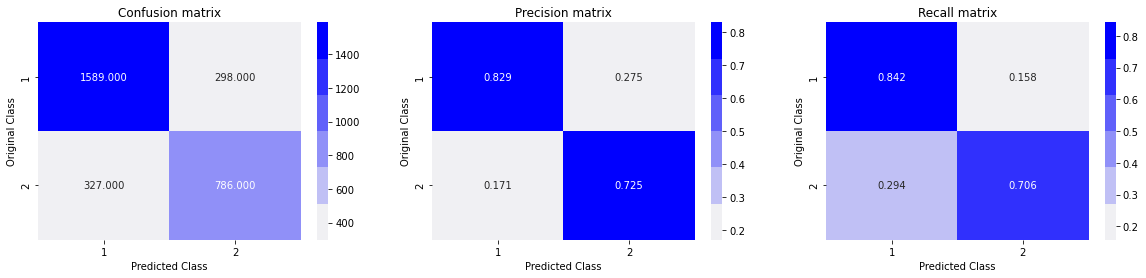

********* dataset *********


,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.749667,0.756333,0.783333,0.791667,0.0
f1_score,0.430026,0.584394,0.617878,0.654989,0.715521,0.0
roc_auc_score,0.514003,0.833234,0.832338,0.873440,0.887183,0.0
log_loss,0.868735,0.483827,0.473798,0.466889,0.403714,0.0


[CV] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__n_estimators=100, method=isotonic; total time=  37.9s
[CV] END base_estimator__criterion=entropy, base_estimator__max_depth=None, base_estimator__n_estimators=100, method=isotonic; total time=  39.3s


In [45]:
rf_clf = rf_clf.best_estimator_
rf_clf.fit(X_train,y_train)
metrics(rf_clf,X_test,y_test,name='RF')
print('********* dataset *********')
result_dataset

## LightGBM

In [47]:
lgbm_clf = LGBMClassifier(random_state = 42)
#param_grids = {'base_estimator__boosting_type':['gbdt','dart','goss','rf'],'base_estimator__max_depth' : [1,2,3,4],'base_estimator__learning_rate' : [0.1,1.0,0.01],'base_estimator__n_estimators':[36,34,35],'base_estimator__subsample': [0.8,0.6],'base_estimator__colsample_bytree': [0.3,0.4,0.5] ,'base_estimator__reg_alpha':[0.7,0.6],'base_estimator__reg_lambda':[0.1,0.0,0.2],'method' : ['sigmoid','isotonic']}
param_grids = {'base_estimator__boosting_type':['gbdt'],'base_estimator__max_depth' : [3],'base_estimator__learning_rate' : [1.0],'base_estimator__n_estimators':[30],'method' : ['sigmoid','isotonic']}
lgbm_clf = GridSearchCV(estimator = CalibratedClassifierCV(base_estimator = lgbm_clf),param_grid = param_grids,cv = 2, scoring = 'neg_log_loss', verbose = 2,n_jobs = -1)
lgbm_clf.fit(X_train,y_train)
lgbm_clf.best_estimator_

Fitting 2 folds for each of 2 candidates, totalling 4 fits


CalibratedClassifierCV(base_estimator=LGBMClassifier(learning_rate=1.0,
                                                     max_depth=3,
                                                     n_estimators=30,
                                                     random_state=42),
                       method='isotonic')

accuracy score : 0.804
f1 score : 0.7197330791229741
auc score : 0.8988801708002597
log loss : 0.394532762758261
classification report : 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      1887
           1       0.77      0.68      0.72      1113

    accuracy                           0.80      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.80      0.80      0.80      3000

*********** confusion matrx ***********


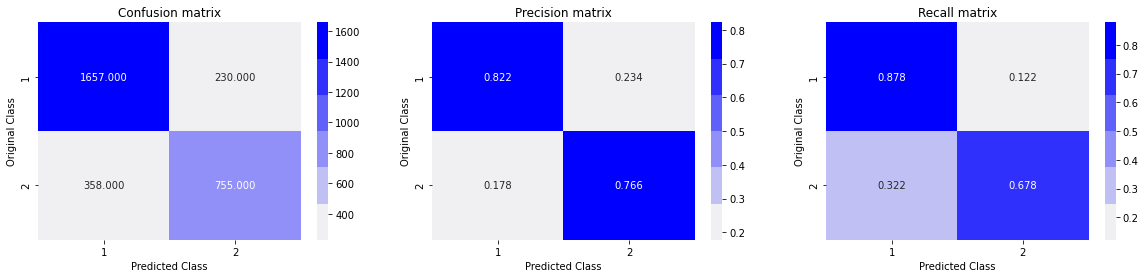

********* dataset *********


,Random,LR,SVC,DT,RF,XGB
accuracy_score,0.496333,0.749667,0.756333,0.783333,0.791667,0.804000
f1_score,0.430026,0.584394,0.617878,0.654989,0.715521,0.719733
roc_auc_score,0.514003,0.833234,0.832338,0.873440,0.887183,0.898880
log_loss,0.868735,0.483827,0.473798,0.466889,0.403714,0.394533


In [48]:
lgbm_clf = lgbm_clf.best_estimator_
lgbm_clf.fit(X_train,y_train)
metrics(lgbm_clf,X_test,y_test,name='XGB')
print('********* dataset *********')
result_dataset

Note: we can make this model far better if we have the compute power 
* To do that just run with commented parameters.